## Company classifier notebook

This is for experimenting with the company fit classifier.
Visualizations, etc can go here.

In [1]:
print("hello world")

hello world


### Setup and Imports

In [2]:
import sys
import os
# Add parent directory to Python path so we can import company_classifier
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from company_classifier.classifier import (
    BAD_FIT,
    GOOD_FIT,
    NEED_MORE_INFO,
    CompanyClassifier,
)

### Load and Prepare Data

In [3]:
labels = {
    GOOD_FIT: "Good fit",
    BAD_FIT: "Bad fit",
    NEED_MORE_INFO: "Need more info",
}

In [4]:
def load_real_data(csv_path: str) -> tuple[pd.DataFrame, np.ndarray]:
    """Load and prepare real company data."""
    df = pd.read_csv(csv_path)

    # Map text categories to numeric values
    category_map = {"good": GOOD_FIT, "bad": BAD_FIT, "needs_more_info": NEED_MORE_INFO}

    # Extract features used by our classifier
    X = df[
        [
            "type",
            "total_comp",
            "base",
            "rsu",
            "bonus",
            "remote_policy",
            "eng_size",
            "total_size",
        ]
    ]

    # Convert fit categories to numeric values
    y = df["fit_category"].map(category_map).to_numpy()

    return X, y

# Load the data
X, y = load_real_data("../company_ratings.csv")

# Show dataset info
print(f"Dataset size: {len(X)} companies\n")
print("Class distribution:")
classes, counts = np.unique(y, return_counts=True)
for cls, count in zip(classes, counts):
    label = labels[cls]
    print(f"{label}: {count}")

Dataset size: 47 companies

Class distribution:
Bad fit: 9
Good fit: 22
Need more info: 16


### Train-Test Split and Initial Evaluation

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Split sizes:")
print(f"Training set: {len(X_train)} companies")
print(f"Test set: {len(X_test)} companies")

# Train and evaluate
print("\nTraining and evaluating classifier...")
classifier = CompanyClassifier()
classifier.fit(X_train, y_train)

# Test set performance
y_pred = classifier.predict(X_test)
print("\nTest Set Performance:")
print(
    classification_report(
        y_test, y_pred, target_names=["Bad fit", "Good fit", "Need more info"]
    )
)

Split sizes:
Training set: 37 companies
Test set: 10 companies

Training and evaluating classifier...

Test Set Performance:
                precision    recall  f1-score   support

       Bad fit       1.00      1.00      1.00         2
      Good fit       0.71      1.00      0.83         5
Need more info       1.00      0.33      0.50         3

      accuracy                           0.80        10
     macro avg       0.90      0.78      0.78        10
  weighted avg       0.86      0.80      0.77        10



/Users/paul/src/recruiter-messager/.direnv/python-3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Cross-Validation Analysis

In [6]:
# Perform cross-validation
cv_results = classifier.cross_validate(
    X, y, cv=5
)

print("Cross-validation results:")
print(
    f"CV Accuracy: {cv_results['test_accuracy'].mean():.2f} (+/- {cv_results['test_accuracy'].std() * 2:.2f})"
)
print(
    f"CV Balanced Accuracy: {cv_results['test_balanced_accuracy'].mean():.2f} (+/- {cv_results['test_balanced_accuracy'].std() * 2:.2f})"
)
print(
    f"CV Precision: {cv_results['test_precision_macro'].mean():.2f} (+/- {cv_results['test_precision_macro'].std() * 2:.2f})"
)
print(
    f"CV Recall: {cv_results['test_recall_macro'].mean():.2f} (+/- {cv_results['test_recall_macro'].std() * 2:.2f})"
)
print(
    f"CV F1: {cv_results['test_f1_macro'].mean():.2f} (+/- {cv_results['test_f1_macro'].std() * 2:.2f})"
)

print("\nTraining vs Test Performance:")
print(f"Training Accuracy: {cv_results['train_accuracy'].mean():.2f}")
print(f"Test Accuracy: {cv_results['test_accuracy'].mean():.2f}")

/Users/paul/src/recruiter-messager/.direnv/python-3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validation results:
CV Accuracy: 0.83 (+/- 0.27)
CV Balanced Accuracy: 0.82 (+/- 0.27)
CV Precision: 0.89 (+/- 0.20)
CV Recall: 0.82 (+/- 0.27)
CV F1: 0.83 (+/- 0.26)

Training vs Test Performance:
Training Accuracy: 1.00
Test Accuracy: 0.83


/Users/paul/src/recruiter-messager/.direnv/python-3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Feature Importance Analysis


<Figure size 1200x600 with 0 Axes>

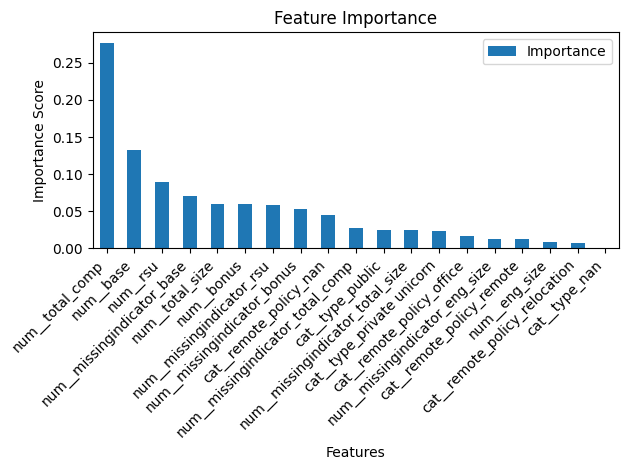

In [7]:
# Analyze feature importance
classifier.fit(X, y)  # Refit on full dataset
importance = classifier.feature_importance()
sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame for better visualization
importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])
importance_df.set_index('Feature', inplace=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
ax = importance_df.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# Let's play with some test cases
good_bad_unknown = pd.DataFrame(
    {
        "type": ["public", "private", None],
        "total_comp": [499000, 200, None],
        "base": [399000, 99, None],
        "bonus": [50000, 0, None],
        "rsu": [50000, 0, None],
        "remote_policy": ["hybrid", "relocation required", None],
        "total_size": [5000, 5, None],
        "eng_size": [1000, 2, None],
    })
result = classifier.predict(good_bad_unknown)
for prediction in result:
    print(labels[prediction])


Good fit
Bad fit
Need more info


/Users/paul/src/recruiter-messager/.direnv/python-3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
